Naive Bayes Classifier

In [20]:
from sklearn.model_selection import train_test_split, cross_validate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB
import csv
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing as pre
from sklearn import impute, metrics
from sklearn.pipeline import Pipeline 

import pandas as pd
import scipy.sparse as sp


Read Data and Downsample the majority class. With the Naive Bayes (Gaussian) classifier, it is especially interesting to look at how an imbalance in the training set will affect the algorithm, as the priors are calculated immediately from the data itself. I will run the algorithm at multiple ratios of MajoritySet:MinortySet (legitimate transactions and fraudulent transactions respectively) to see how this affects the various evaluation scores of the model.

In [13]:
data =  pd.read_csv('./data/train_data_clean_reduced_encoded.csv')
df = pd.DataFrame(data)


In [23]:

accs = []
balanced = []
f1s = []
iters = 10
x_axis = np.arange(1,26,3)

for i in range(1,28,3):
    X = df

    # #Downsampling

    #mult is ratio of legitimate data to fraudulent data, max is 27
    mult = i

    fClass = X[X['0'] == 1]
    lClass = X[X['0'] == 0]

    fCount = int(len(fClass) * mult)

    #downsample
    lClass = lClass.sample(fCount, axis=0)

    X = pd.concat([fClass.reset_index(drop=True), lClass.reset_index(drop=True)],axis=0)

    #shuffle data for no particular reason
    X.sample(frac = 1)
    #End downsampling


    y =np.array(X['0'])
    X = X.drop(columns=['0'])

    gnb = GaussianNB()
    scores = cross_validate(gnb,X,y, scoring = ['accuracy','balanced_accuracy','f1'] )
        
    accs.append(scores['test_accuracy'])
    balanced.append(scores['test_balanced_accuracy'])
    f1s.append(scores['test_f1'])


{'fit_time': array([0.05780673, 0.06079698, 0.05979967, 0.0617938 , 0.09893513]), 'score_time': array([0.01993322, 0.01993227, 0.01993346, 0.03089643, 0.02092957]), 'test_accuracy': array([0.71310285, 0.70419875, 0.71945373, 0.71306117, 0.7166933 ]), 'test_balanced_accuracy': array([0.71310285, 0.70423361, 0.71948646, 0.71302661, 0.71665876]), 'test_f1': array([0.62573432, 0.61085627, 0.63791487, 0.62345091, 0.62828822])}
{'fit_time': array([0.14053082, 0.1987884 , 0.14651012, 0.14949989, 0.15290284]), 'score_time': array([0.0448494 , 0.04385328, 0.0717597 , 0.04612231, 0.04484963]), 'test_accuracy': array([0.85344026, 0.84908182, 0.85169689, 0.8498954 , 0.85094142]), 'test_balanced_accuracy': array([0.70532773, 0.70347517, 0.71698442, 0.70401622, 0.7070677 ]), 'test_f1': array([0.55582952, 0.54983533, 0.57051498, 0.55117289, 0.55630514])}
{'fit_time': array([0.22723961, 0.28535581, 0.26112652, 0.23694873, 0.22125936]), 'score_time': array([0.07474899, 0.07275534, 0.06976628, 0.1156127

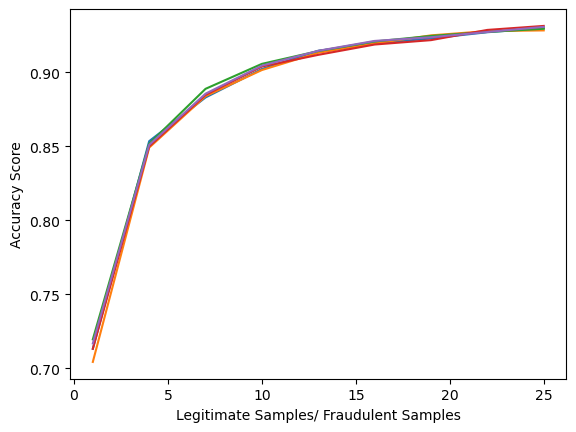

In [27]:
plt.plot(x_axis, accs)
plt.ylabel('Accuracy Score')
plt.xlabel('Legitimate Samples/ Fraudulent Samples')
plt.show()


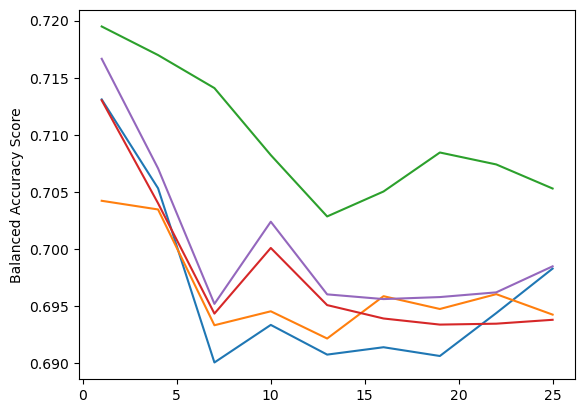

In [28]:
plt.plot(x_axis, balanced)
plt.ylabel('Balanced Accuracy Score')
plt.xlabel('Legitimate Samples/ Fraudulent Samples')

plt.show()


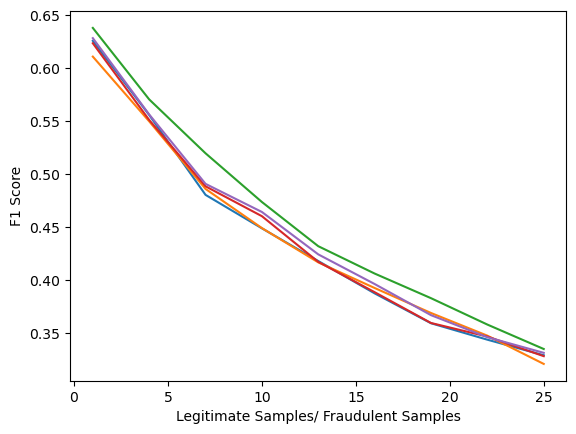

In [29]:
plt.plot(x_axis, f1s)
plt.ylabel('F1 Score')
plt.xlabel('Legitimate Samples/ Fraudulent Samples')

plt.show()


The plots here indicate that the model rapidly begins to overfit as the dataset becomes unbalanced. The F1 score, which measures the harmonic mean of precision and recall, indicates that the model becomes increasingly skewed towards labeling all data as legitimate, which could indicate especially that the Bayesian Priors are having a significant effect on the fitting of the model.

This is somewhat surprising to us, as we suspected that there would be some benefit to the skewed Priors for unbalanced data. This relationship was not supported by the performance of the model.


As F1 score is particularly useful for measuring the performance of a classifier with imbalanced data, this should be considered far more heavily than the accuracy, which likely indicates that the model is rapidly overfitting.




Fixing this ratio at 1, we will test the performance of our model on the test set, which was cleaned separately.

In [40]:
X = df

mult = 1

fClass = X[X['0'] == 1]
lClass = X[X['0'] == 0]

fCount = int(len(fClass) * mult)

#downsample
lClass = lClass.sample(fCount, axis=0)

X = pd.concat([fClass.reset_index(drop=True), lClass.reset_index(drop=True)],axis=0)

#shuffle data for no particular reason
X.sample(frac = 1)
#End downsampling


y =np.array(X['0'])
X = X.drop(columns=['0'])

gnb = GaussianNB()
fit = gnb.fit(X, y)

test = pd.read_csv('./data/test_data_clean_reduced_encoded.csv')
test_df = pd.DataFrame(test)

TEST_X = test_df.drop(columns=['0'])
TEST_y = np.array(test_df['0'])

TEST_pred = fit.predict(TEST_X)
TEST_acc = metrics.accuracy_score(TEST_y, TEST_pred)
print(TEST_acc * 100, "% Accuracy")
balanced_TEST_acc = metrics.balanced_accuracy_score(TEST_y, TEST_pred)
print(balanced_TEST_acc * 100, '% Balanced Accuracy')
f1 = metrics.f1_score(TEST_y, TEST_pred)
print(f1, 'F1 Score')

92.29899999999999 % Accuracy
69.2900111290829 % Balanced Accuracy
0.285687784064558 F1 Score


Even with a balance between the two class labels in the training set, the F1 score of the data on the test set is low. It is possible that simply more data is required to improve the performance of the Naive Bayesian Classifier. As such, we might explore upsampling techniques in the future to balance the data while providing more samples. This, like many things, is difficult in high dimensions, our current FAMD approach to data representation should help with this matter.  